# Diff in Diff: Does Air Quality Matter? Evidence from the Housing Market

This document will replicate the main results from Chay and Greenstone (2005): https://www.jstor.org/stable/10.1086/427462 .
**Overview:**
We are not going to replicate the whole paper, but simply explore the effect of the CAA (Clean Air Act) on air pollution using the diff-in-diff method.

**Setup:** The Clean Air Act is a United States federal law enacted in 1970 to regulate air emissions from stationary and mobile sources. The act aims to protect human health and the environment by establishing national air quality standards and setting limits on the amount of pollutants that can be released into the air. 
Importantly, there is a clear threshold: counties treated are the ones that have a mean annual total suspended particles above 75 $\mu 𝑔/𝑚^3$ or the second-highest daily concentration above 260  $\mu 𝑔/𝑚^3$ . The main limitation comes from the impossibility to test the parallel trends assumption and finding a good control.

## 1. Variables selection
- **outcome:** concentration of TSP
- **explanatory variable:** Clean Air Act
- **heterogeneity:** Before/Above treatment in 1970

## 2. Sample selection
We have a panel dataset with the average value for control or treated regions from 1967 to 1975.

List of main variables:
- *year*
- *tsp:* Total suspended particules in $\mu 𝑔/𝑚^3$ 
- *treated:* 1 for treated observations, 0 otherwise
- *post:* 1 for the post period, 0 otherwise

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import numpy as np
import linearmodels as lm
from linearmodels import PanelOLS
from linearmodels.panel import generate_panel_data
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

In [2]:
df = pd.read_excel("./chay_greenstone_1.xlsx")
df

,year,tsp,post,treated
0,1967,63.3,0,0
1,1968,60.0,0,0
2,1969,57.3,0,0
3,1970,58.8,0,0
4,1971,54.0,1,0
5,1972,53.5,1,0
6,1973,52.9,1,0
7,1974,49.1,1,0
8,1975,48.4,1,0
9,1967,98.0,0,1


**Note:** No need to clean the data.

## 3. Univariate analysis
### 3.1 Total Suspended Particulate
- Total suspended particulate (TSP) are tiny solid or liquid particles that are suspended in air or water. These particles can be in the form of dust, smoke, pollen, or other pollutants, and they can range in size from 0.001 to 100 micrometers. TSP can affect air and water quality, and they can also be inhaled by humans and animals, potentially causing health problems.

In [3]:
df['tsp'].describe()

count    18.000000
mean     69.838889
std      17.507112
min      48.400000
25%      54.825000
50%      65.100000
75%      86.400000
max      98.000000
Name: tsp, dtype: float64

Skewness tsp: 
0.44550134836099775


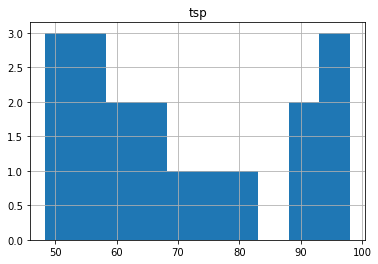

In [4]:
#histogram and skewness
df.hist(column='tsp')

print("Skewness tsp: ")
print(skew(df['tsp'], nan_policy='omit'))

**Note:** We have only 18 datapoints.

## 4 Bivariate analysis
### 4.1 Figure 1

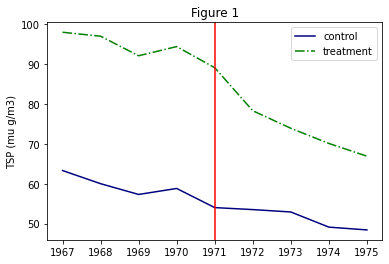

In [5]:
plt.plot(df[(df['treated'] == 0)]['year'],
         df[(df['treated'] == 0)]['tsp'],
         color = "navy", linestyle = '-', label = "control")

plt.plot(df[(df['treated'] == 1)]['year'],
         df[(df['treated'] == 1)]['tsp'],
         color = "green", linestyle = '-.', label = "treatment")


plt.title("Figure 1")
plt.xlabel("")
plt.ylabel("TSP (mu g/m3)")
plt.axvline(x=1971, ymin=0, ymax=100, color='red')
plt.legend()

## 5 Multivariate analysis
### 5.1 Main model

In [6]:
# Set the index for fixed effects
df['id'] = df['treated']
df['t'] = df['year']
df.reset_index(inplace=True)
df = df.set_index(['id', 't'])

In [7]:
reg1 = PanelOLS.from_formula("tsp ~ treated*post+1", df)
res = reg1.fit(cov_type = 'clustered')
             #cluster_entity=True,
             # cluster_time=True
              
res

Dep. Variable:,tsp,R-squared:,0.9296
Estimator:,PanelOLS,R-squared (Between):,1.0000
No. Observations:,18,R-squared (Within):,0.7348
Date:,"Mon, Jan 09 2023",R-squared (Overall):,0.9296
Time:,13:32:25,Log-likelihood,-52.667
Cov. Estimator:,Clustered,,
,,F-statistic:,61.654
Entities:,2,P-value,0.0000
Avg Obs:,9.0000,Distribution:,"F(3,14)"
Min Obs:,9.0000,,
Max Obs:,9.0000,F-statistic (robust):,225.39


### 5.2 Parallel (pre) trends

In [9]:
df_placebo = df.loc[df['year'] <= 1971,:]
df_placebo.loc[df_placebo['year'] >1969,'post'] = 1
df_placebo

index  year   tsp  post  treated
id t                                     
0  1967      0  1967  63.3     0        0
   1968      1  1968  60.0     0        0
   1969      2  1969  57.3     0        0
   1970      3  1970  58.8     1        0
   1971      4  1971  54.0     1        0
1  1967      9  1967  98.0     0        1
   1968     10  1968  97.0     0        1
   1969     11  1969  92.1     0        1
   1970     12  1970  94.4     1        1
   1971     13  1971  89.1     1        1

In [10]:
reg2 = PanelOLS.from_formula("tsp ~ treated*post+1", df_placebo)
res = reg2.fit(cov_type = 'clustered')
             #cluster_entity=True,
             # cluster_time=True
              
res

Dep. Variable:,tsp,R-squared:,0.9804
Estimator:,PanelOLS,R-squared (Between):,1.0000
No. Observations:,10,R-squared (Within):,0.3619
Date:,"Mon, Jan 09 2023",R-squared (Overall):,0.9804
Time:,13:32:26,Log-likelihood,-23.437
Cov. Estimator:,Clustered,,
,,F-statistic:,99.930
Entities:,2,P-value,0.0000
Avg Obs:,5.0000,Distribution:,"F(3,6)"
Min Obs:,5.0000,,
Max Obs:,5.0000,F-statistic (robust):,100.51


In [11]:
df_placebo = df.loc[df['year'] <= 1971,:]
df_placebo.loc[df_placebo['year'] >1968,'post'] = 1
df_placebo

reg3 = PanelOLS.from_formula("tsp ~ treated*post+1", df_placebo)
res = reg3.fit(cov_type = 'clustered')
             #cluster_entity=True,
             # cluster_time=True
              
res

Dep. Variable:,tsp,R-squared:,0.9901
Estimator:,PanelOLS,R-squared (Between):,1.0000
No. Observations:,10,R-squared (Within):,0.6774
Date:,"Mon, Jan 09 2023",R-squared (Overall):,0.9901
Time:,13:32:26,Log-likelihood,-20.026
Cov. Estimator:,Clustered,,
,,F-statistic:,199.65
Entities:,2,P-value,0.0000
Avg Obs:,5.0000,Distribution:,"F(3,6)"
Min Obs:,5.0000,,
Max Obs:,5.0000,F-statistic (robust):,369.28


## 6. Conclusion
This is just a toy model. That being said, the results are encouraging. We observe a statistically significant effect of the diff in diff estimator. Additionally, we don't find an effect for a placebo pre-treatment period. 